# Q1

Gaussian Processes (GPs) and Stochastic Processes
- Stochastic Process: A collection of random variables indexed by time or space, e.g., $\left\{X_t\right\}_{t \in T}$, where each $X_t$ is a random variable.
- Gaussian Process: A stochastic process $f(x)$ where for any finite set $x_1, \ldots, x_n$, the joint distribution $\left(f\left(x_1\right), \ldots, f\left(x_n\right)\right)$ is multivariate normal. Specified by:

$$
f(x) \sim \mathcal{G P}\left(m(x), k\left(x, x^{\prime}\right)\right)
$$

where $m(x)$ is the mean function and $k\left(x, x^{\prime}\right)$ is the covariance (kernel) function.

Variational Inference using ELBO
- Variational Inference (VI) approximates the true posterior $p(\theta \mid x)$ with a simpler distribution $q(\theta)$ by minimizing KL divergence:

$$
\mathrm{KL}(q(\theta) \| p(\theta \mid x))=\log p(x)-\operatorname{ELBO}(q)
$$

- Evidence Lower Bound (ELBO):

$$
\operatorname{ELBO}(q)=\mathbb{E}_{q(\theta)}[\log p(x, \theta)]-\mathbb{E}_{q(\theta)}[\log q(\theta)]
$$


Maximizing ELBO $\approx$ maximizing the marginal likelihood while regularizing with KL divergence.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ℓ, η, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f_pred]


KeyError: 'f_pred'

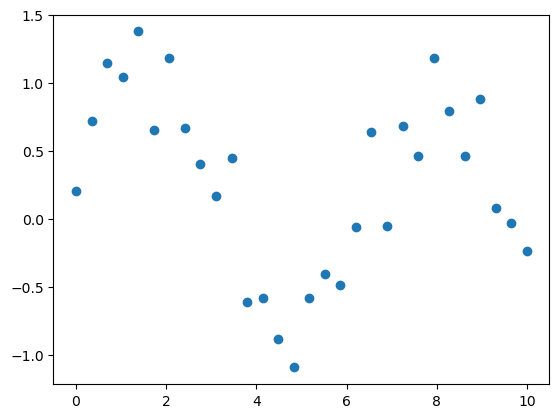

In [1]:
# Q2
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Simulated dataset: 1D location → house price
X = np.linspace(0, 10, 30)[:, None]
y = np.sin(X).ravel() + 0.3 * np.random.randn(30)

with pm.Model() as gp_model:
    # Define GP prior
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfNormal("η", sigma=1)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    gp = pm.gp.Marginal(cov_func=cov_func)
    σ = pm.HalfNormal("σ", sigma=0.5)
    
    y_obs = gp.marginal_likelihood("y", X=X, y=y, sigma=σ)
    
    trace = pm.sample(1000, chains=2)

    # Posterior predictive
    X_new = np.linspace(0, 10, 100)[:, None]
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"], model=gp_model)

# Plot
plt.plot(X, y, "o", label="Observed data")
plt.plot(X_new, pred_samples["f_pred"].mean(0), label="Posterior mean")
plt.fill_between(X_new.ravel(), 
                 np.percentile(pred_samples["f_pred"], 5, axis=0),
                 np.percentile(pred_samples["f_pred"], 95, axis=0), alpha=0.3)
plt.legend()
plt.show()

In [ ]:
# Q3
import pymc as pm
import numpy as np
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Simulate logistic data
np.random.seed(42)
X = np.random.randn(200, 2)
w_true = np.array([1.5, -2.0])
logits = X @ w_true
y = np.random.binomial(n=1, p=1 / (1 + np.exp(-logits)))

with pm.Model() as vi_model:
    # Bayesian NN with one hidden layer
    weights_1 = pm.Normal("w1", mu=0, sigma=1, shape=(2, 5))
    bias_1 = pm.Normal("b1", mu=0, sigma=1, shape=(5,))
    
    weights_2 = pm.Normal("w2", mu=0, sigma=1, shape=(5,))
    bias_2 = pm.Normal("b2", mu=0, sigma=1)
    
    hidden = pm.math.tanh(pt.dot(X, weights_1) + bias_1)
    out = pm.math.dot(hidden, weights_2) + bias_2
    
    y_obs = pm.Bernoulli("y_obs", logit_p=out, observed=y)
    
    approx = pm.fit(10000, method="advi", obj_optimizer=pm.adagrad(learning_rate=0.01))
    trace_vi = approx.sample(1000)